In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = "C:/Users/Yacoub/Downloads/archiveee/chest_xray/train"
val_dir = "C:/Users/Yacoub/Downloads/archiveee/chest_xray/val"
test_dir = "C:/Users/Yacoub/Downloads/archiveee/chest_xray/test"

In [ ]:
image_size = (224, 224)

In [ ]:
def load_images_from_directory(directory, image_size):
    images = []
    labels = []
    for class_label in os.listdir(directory):
        class_dir = os.path.join(directory, class_label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(1 if class_label == 'PNEUMONIA' else 0)
    return np.array(images), np.array(labels)

In [ ]:
X_train, y_train = load_images_from_directory(train_dir, image_size)
X_val, y_val = load_images_from_directory(val_dir, image_size)
X_test, y_test = load_images_from_directory(test_dir, image_size)

In [ ]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
print("Images d'entraînement:", X_train.shape)
print("Images de validation:", X_val.shape)
print("Images de test:", X_test.shape)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Poids des classes:", class_weights)

In [ ]:
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in inception_base.layers:
    layer.trainable = False
model_inception = Sequential()
model_inception.add(inception_base)
model_inception.add(GlobalAveragePooling2D())
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dropout(0.5))
model_inception.add(BatchNormalization())
model_inception.add(Dense(1, activation='sigmoid'))
model_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3)

In [12]:
history_inception=model_inception.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
163/163 [==============================] - 827s 5s/step - loss: 0.3177 - accuracy: 0.8250 - val_loss: 0.3886 - val_accuracy: 0.8241 - lr: 1.0000e-04
Epoch 2/50
163/163 [==============================] - 1070s 7s/step - loss: 0.2389 - accuracy: 0.8800 - val_loss: 0.4176 - val_accuracy: 0.8056 - lr: 1.0000e-04
Epoch 3/50
163/163 [==============================] - 1052s 6s/step - loss: 0.2044 - accuracy: 0.9133 - val_loss: 0.3940 - val_accuracy: 0.8380 - lr: 1.0000e-04
Epoch 4/50
163/163 [==============================] - 1058s 6s/step - loss: 0.1835 - accuracy: 0.9264 - val_loss: 0.4970 - val_accuracy: 0.7731 - lr: 1.0000e-04
Epoch 5/50
163/163 [==============================] - 1045s 6s/step - loss: 0.1663 - accuracy: 0.9352 - val_loss: 0.4128 - val_accuracy: 0.8194 - lr: 2.0000e-05
Epoch 6/50
163/163 [==============================] - 1046s 6s/step - loss: 0.1524 - accuracy: 0.9388 - val_loss: 0.4074 - val_accuracy: 0.8194 - lr: 2.0000e-05


In [15]:
test_loss, test_accuracy = model_inception.evaluate(X_test, y_test, verbose=1)
print(f"Loss sur le jeu de test : {test_loss:.4f}")
print(f"Accuracy sur le jeu de test : {test_accuracy:.4f}")

14/14 [==============================] - 61s 4s/step - loss: 0.3573 - accuracy: 0.8561
Loss sur le jeu de test : 0.3573
Accuracy sur le jeu de test : 0.8561


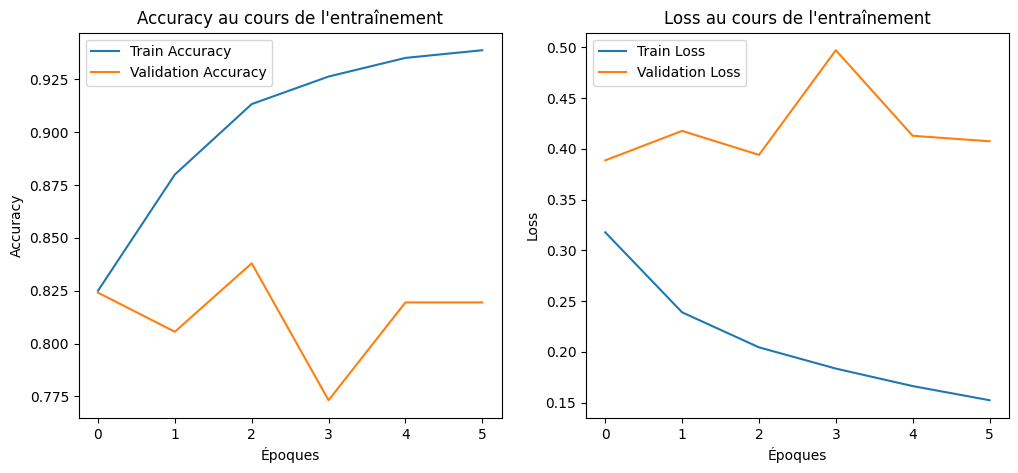

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy au cours de l\'entraînement')
    plt.xlabel('Époques')
    plt.ylabel('Accuracy')
    plt.legend()

    # Courbe de perte (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss au cours de l\'entraînement')
    plt.xlabel('Époques')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Affichage des courbes
plot_history(history_inception)


14/14 [==============================] - 75s 5s/step
Matrice de confusion:
 [[ 92  42]
 [ 19 271]]
Rapport de classification:
               precision    recall  f1-score   support

      NORMAL       0.83      0.69      0.75       134
   PNEUMONIA       0.87      0.93      0.90       290

    accuracy                           0.86       424
   macro avg       0.85      0.81      0.82       424
weighted avg       0.85      0.86      0.85       424



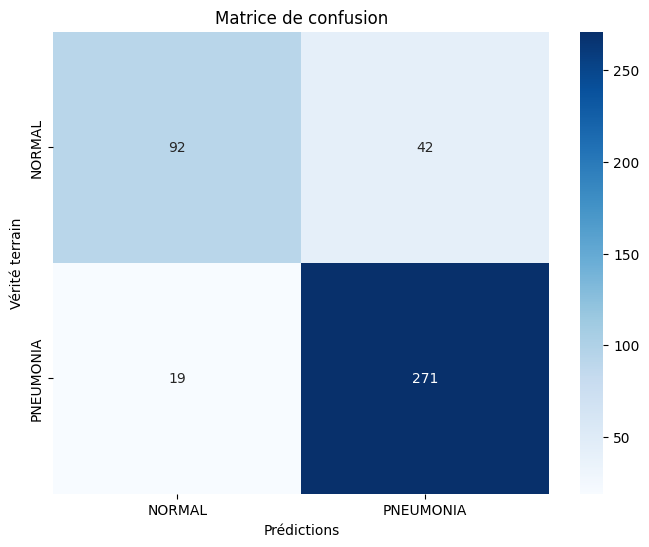

In [18]:
y_pred = model_inception.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Matrice de confusion:\n", conf_matrix)
class_report = classification_report(y_test, y_pred_class, target_names=['NORMAL', 'PNEUMONIA'])
print("Rapport de classification:\n", class_report)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.show()

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
datagen.fit(X_train)

In [ ]:
history_model_inception_aug = model_inception.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)